<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024Project/blob/Klasyfikacja_z_wykorzystaniem_drzew_decyzyjnych_RG/Klasyfikacja_drzewa_decyzyjne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasyfikacja z wykorzystaniem drzew decyzyjnych

## Wczytywanie danych w sparku

Utworzenie środowiska pyspark do obliczeń:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/PiotrMaciejKowalski/BigData2024Project.git
%cd BigData2024Project
!git checkout refactoring-sprint2
%cd ..

Cloning into 'BigData2024Project'...
remote: Enumerating objects: 1419, done.
remote: Counting objects: 100% (765/765), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 1419 (delta 503), reused 524 (delta 342), pack-reused 654
Receiving objects: 100% (1419/1419), 54.41 MiB | 8.25 MiB/s, done.
Resolving deltas: 100% (766/766), done.
/content/BigData2024Project
Branch 'refactoring-sprint2' set up to track remote branch 'refactoring-sprint2' from 'origin'.
Switched to a new branch 'refactoring-sprint2'
/content


In [ ]:
!chmod 755 /content/BigData2024Project/src/setup.sh
!/content/BigData2024Project/src/setup.sh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.6/306.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 40.0 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.1.0
    Uninstalling platformdirs-4.1.0:
      Successfully uninstalled platformdirs-4.1.0
  Attempting uninstall: keyring
    Found existing installation: keyring 23.5.0
    Uninstalli

In [ ]:
import sys
sys.path.append('/content/BigData2024Project/src')

In [ ]:
from start_spark import initialize_spark
initialize_spark()

In [ ]:
from pyspark.sql import SparkSession

from big_mess.loaders import preprocessed_loader

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
data=preprocessed_loader(spark,'/content/drive/MyDrive/BigMess/NASA/NASA_anotated_preprocessed.csv')

In [ ]:
data.show()

+---------+-------+--------+--------+--------+--------+-------------+----------+--------+---------+---------------+--------------+----+-----+--------+----+
|      lon|    lat|   Rainf|    Evap|AvgSurfT|  Albedo|SoilT_10_40cm|      GVEG| PotEvap|RootMoist|SoilM_100_200cm|SoilT_40_100cm|Year|Month|pustynia|step|
+---------+-------+--------+--------+--------+--------+-------------+----------+--------+---------+---------------+--------------+----+-----+--------+----+
|-112.0625|25.4375|   1.403|11.82041|287.8039|41.51882|     289.0886| 0.1682641|131.0754| 425.6864|       224.6146|          NULL|2023|    1|       1|   0|
|-109.0625|25.6875|  1.4716|14.04781|287.6204|30.31183|     289.3364| 0.4438815|  136.33|  99.6714|       198.1852|          NULL|2023|    1|       1|   0|
|-102.1875|26.3125|     0.0|3.987099| 279.181|41.64651|     280.7906| 0.1470791|148.4581| 157.0257|       174.5081|          NULL|2023|    1|       1|   0|
| -98.6875|26.4375|  0.1712|11.72601| 290.488|30.52419|     290.

## Budowa modeli

**Cel**:

Celem jest zbudowanie modeli do klasyfikacji czy wskazany punkt lokalizacyjny ze zbioru danych NASA jest: pustynia, stepem lub innym obszarem. Zbudowane zostana trzy modele:

* Model 1 - detekcja pustynia - step - inne
* Model 2 - detekcja pustynia - niepustynia
* Model 3 - detekcja step - niestep


**Proba danych**:

Dane wykorzystane do modelowania zostały stworzone po przez połączenie dwoch zbiorów danych:

* 500 lokalizacji *lon* i *lat* z określoną flagą 0, 1 w kolumnach *pustynia* lub *step* (reczna adnotacja)
* danych NASA z *stycznia 2023*

**Metoda**:

Do modelowania uzyto metody drzew decyzyjnych.


### Import bibliotek

In [ ]:
from typing import List
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

### Przygotowanie danych

In [ ]:
df = (
    data
    .drop('SoilT_40_100cm') #remove after fixing null values there
    .toPandas()
)
df.head()

,lon,lat,Rainf,Evap,AvgSurfT,Albedo,SoilT_10_40cm,GVEG,PotEvap,RootMoist,SoilM_100_200cm,Year,Month,pustynia,step
0,-112.0625,25.4375,1.4030,11.820410,287.8039,41.51882,289.0886,0.168264,131.0754,425.6864,224.6146,2023,1,1,0
1,-109.0625,25.6875,1.4716,14.047810,287.6204,30.31183,289.3364,0.443881,136.3300,99.6714,198.1852,2023,1,1,0
2,-102.1875,26.3125,0.0000,3.987099,279.1810,41.64651,280.7906,0.147079,148.4581,157.0257,174.5081,2023,1,1,0
3,-98.6875,26.4375,0.1712,11.726010,290.4880,30.52419,290.4983,0.139884,122.3659,147.6437,179.9277,2023,1,1,0
4,-102.9375,26.5625,0.0000,5.678200,279.1231,41.64785,280.6321,0.129287,152.9563,309.3300,148.0312,2023,1,0,1


Dodanie kolumny *klasa* z nastepujacym oslownikowaniem:

* **1** - pustynia
* **2** - step
* **3** - inne

In [ ]:
df['klasa'] = np.where(
                        df['pustynia'] == 1, 1, np.where(
                        df['step'] == 1,2,3)
                        )

Liczebnosci poszczegolnych klas w probce.

In [ ]:
{1:df['pustynia'].sum(), 2:df['step'].sum() , 3:df['pustynia'].count()- df['pustynia'].sum()- df['step'].sum()}

{1: 69, 2: 87, 3: 344}

In [ ]:
print(df.shape)

(500, 16)


In [ ]:
df.head(5)

,lon,lat,Rainf,Evap,AvgSurfT,Albedo,SoilT_10_40cm,GVEG,PotEvap,RootMoist,SoilM_100_200cm,Year,Month,pustynia,step,klasa
0,-112.0625,25.4375,1.4030,11.820410,287.8039,41.51882,289.0886,0.168264,131.0754,425.6864,224.6146,2023,1,1,0,1
1,-109.0625,25.6875,1.4716,14.047810,287.6204,30.31183,289.3364,0.443881,136.3300,99.6714,198.1852,2023,1,1,0,1
2,-102.1875,26.3125,0.0000,3.987099,279.1810,41.64651,280.7906,0.147079,148.4581,157.0257,174.5081,2023,1,1,0,1
3,-98.6875,26.4375,0.1712,11.726010,290.4880,30.52419,290.4983,0.139884,122.3659,147.6437,179.9277,2023,1,1,0,1
4,-102.9375,26.5625,0.0000,5.678200,279.1231,41.64785,280.6321,0.129287,152.9563,309.3300,148.0312,2023,1,0,1,2


Sprawdzenie, czy w danych występują braki - nie.

In [ ]:
df.isnull().sum()

lon                0
lat                0
Rainf              0
Evap               0
AvgSurfT           0
Albedo             0
SoilT_10_40cm      0
GVEG               0
PotEvap            0
RootMoist          0
SoilM_100_200cm    0
Year               0
Month              0
pustynia           0
step               0
klasa              0
dtype: int64

#### Wydzielenie zbiorow danych

Zmienne kandydatki:

* **GVEG** - wskaznik roslinnosci
* **Rainf** - wskaznik opadow deszczu
* **Evap** - wskaznik calkowitej ewapotranspiracji
* **AvgSurfT** - wskaznik sredniej temperatury powierzchni ziemi
* **Albedo** - wskaznik albedo
* **SoilT_40_100cm** - wskaznik temperatury gleby w warstwie o glebokosci od 40 do 100 cm
* **PotEvap** - wskaznik potencjalnej ewapotranspiracji
* **RootMoist** - wilgotnosć gleby w strefie korzeniowej (parowanie, ktore mialoby miejsce, gdyby dostepne bylo wystarczajace zrodlo wody)
* **SoilM_100_200cm** - wilgotnosc gleby w warstwie o glebokosci od 100 do 200 cm




In [ ]:
X = df.loc[:,'Rainf':'SoilM_100_200cm']
y_m1 = df['klasa']
y_m2 = df['pustynia']
y_m3 = df['step']

#### Definiowanie funkcji

In [ ]:
def information_gain(X: pd.DataFrame, y: pd.DataFrame) -> None:
  importances = mutual_info_classif(X, y)
  feature_info = pd.Series(importances, X.columns).sort_values(ascending=False)
  print(feature_info)

In [ ]:
def correlations(X: pd.DataFrame) -> None:
  cor = X.corr()
  sns.heatmap(cor, annot=True,cmap='Reds')

In [ ]:
def plot_data_dist(y: pd.DataFrame) -> None:
  dane = pd.Series(y).value_counts().sort_index()
  labels = list(np.sort(pd.unique(y)))
  ypos=np.arange(len(labels))
  plt.xticks(ypos, labels)
  plt.xlabel('Klasa')
  plt.ylabel('Czestosc')
  plt.title('Liczebnosc dla proby')
  plt.bar(ypos,dane)

In [ ]:
def summary_model(model, X:pd.DataFrame, y:pd.DataFrame, labels_names: List) -> None:
  y_pred = model.predict(X)
  y_real= y
  cf_matrix = confusion_matrix(y_real, y_pred)
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(len(labels_names),len(labels_names))
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds',xticklabels=labels_names,yticklabels=labels_names)
  plt.xlabel('Predykcja')
  plt.ylabel('Rzeczywistość')
  plt.show()

In [ ]:
def print_classification_report(model, X: pd.DataFrame, y: pd.DataFrame) -> None:
  y_predict = model.predict(X)
  print(classification_report(y, y_predict))

In [ ]:
from typing import Optional, Tuple
from pandas import DataFrame
from imblearn.over_sampling import RandomOverSampler, SMOTE

class BalanceDataSet():
  '''
  Two techniques for handling imbalanced data.
  '''
  def __init__(
      self,
      X: DataFrame,
      y: DataFrame
      ) -> None:
      self.X = X
      self.y = y
      assert len(self.X)==len(self.y)

  def useOverSampling(
      self,
      randon_seed: Optional[int] = 2023
      ) -> Tuple[DataFrame, DataFrame]:
    oversample = RandomOverSampler( sampling_strategy='auto',
                  random_state=randon_seed)
    return oversample.fit_resample(self.X, self.y)

  def useSMOTE(
      self,
      randon_seed: Optional[int] = 2023
      ) -> Tuple[DataFrame, DataFrame]:
    smote = SMOTE(random_state=randon_seed)
    return smote.fit_resample(self.X, self.y)

### Model 1 - detekcja pustynia - step - inne

#### Podzial na zbior treningowy i testowy

In [ ]:
X_m1_train, X_m1_test, y_m1_train, y_m1_test = train_test_split(X, y_m1, test_size=0.2, random_state=2023)

#### Analiza jednoczynnikowa

Obliczmy zysk informacji.

In [ ]:
information_gain(X_m1_train, y_m1_train)

Albedo             0.172403
RootMoist          0.154887
Rainf              0.091107
SoilM_100_200cm    0.079096
GVEG               0.061006
AvgSurfT           0.049164
Evap               0.041566
PotEvap            0.041017
SoilT_10_40cm      0.038744
dtype: float64


#### Analiza wieloczynnikowa

Obliczmy korelacje zmiennych.

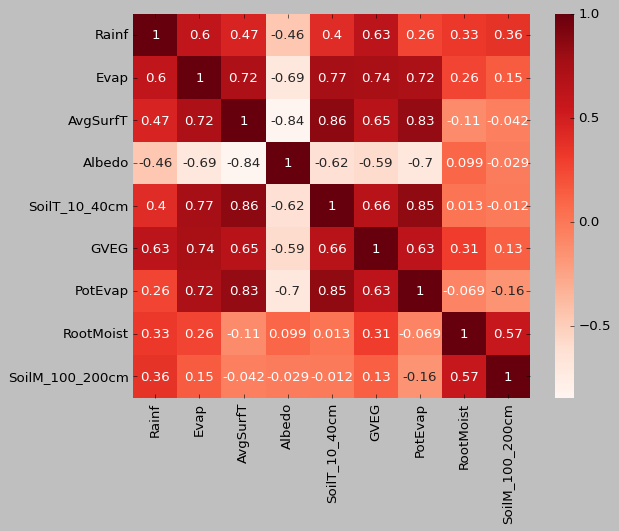

In [ ]:
correlations(X_m1_train)

Usuniecie zmiennej *SoilT_10_40cm*. Cechuja sie ona mała wartoscia zysku informacji. (Accurancy z tymi zmiennymi 77% dla zbioru testowego.)

In [ ]:
X_m1_train = X_m1_train.drop('SoilT_10_40cm',axis=1)
X_m1_test = X_m1_test.drop('SoilT_10_40cm',axis=1)

#### Zbalansowanie datasetu

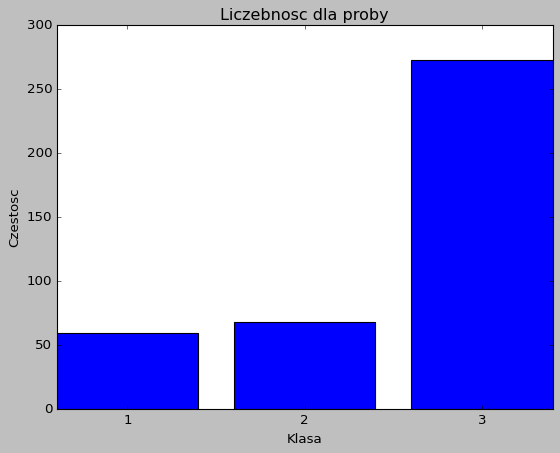

In [ ]:
plot_data_dist(y_m1_train)

In [ ]:
X_m1_train_bal, y_m1_train_bal = BalanceDataSet(X_m1_train, y_m1_train).useSMOTE()

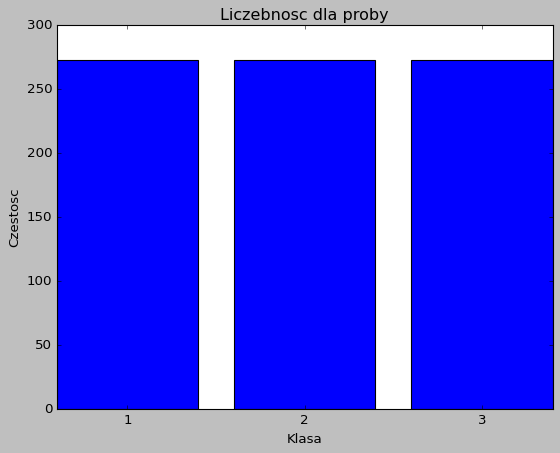

In [ ]:
plot_data_dist(y_m1_train_bal)

#### Drzewa decyzyjne

In [ ]:
tree_classifier_m1 = tree.DecisionTreeClassifier(random_state = 2023)

In [ ]:
tree_classifier_m1.fit(X_m1_train_bal, y_m1_train_bal)

DecisionTreeClassifier(random_state=2023)

In [ ]:
print("classifier accuracy {:.2f}%".format(tree_classifier_m1.score(X_m1_test,  y_m1_test) * 100))

classifier accuracy 79.00%


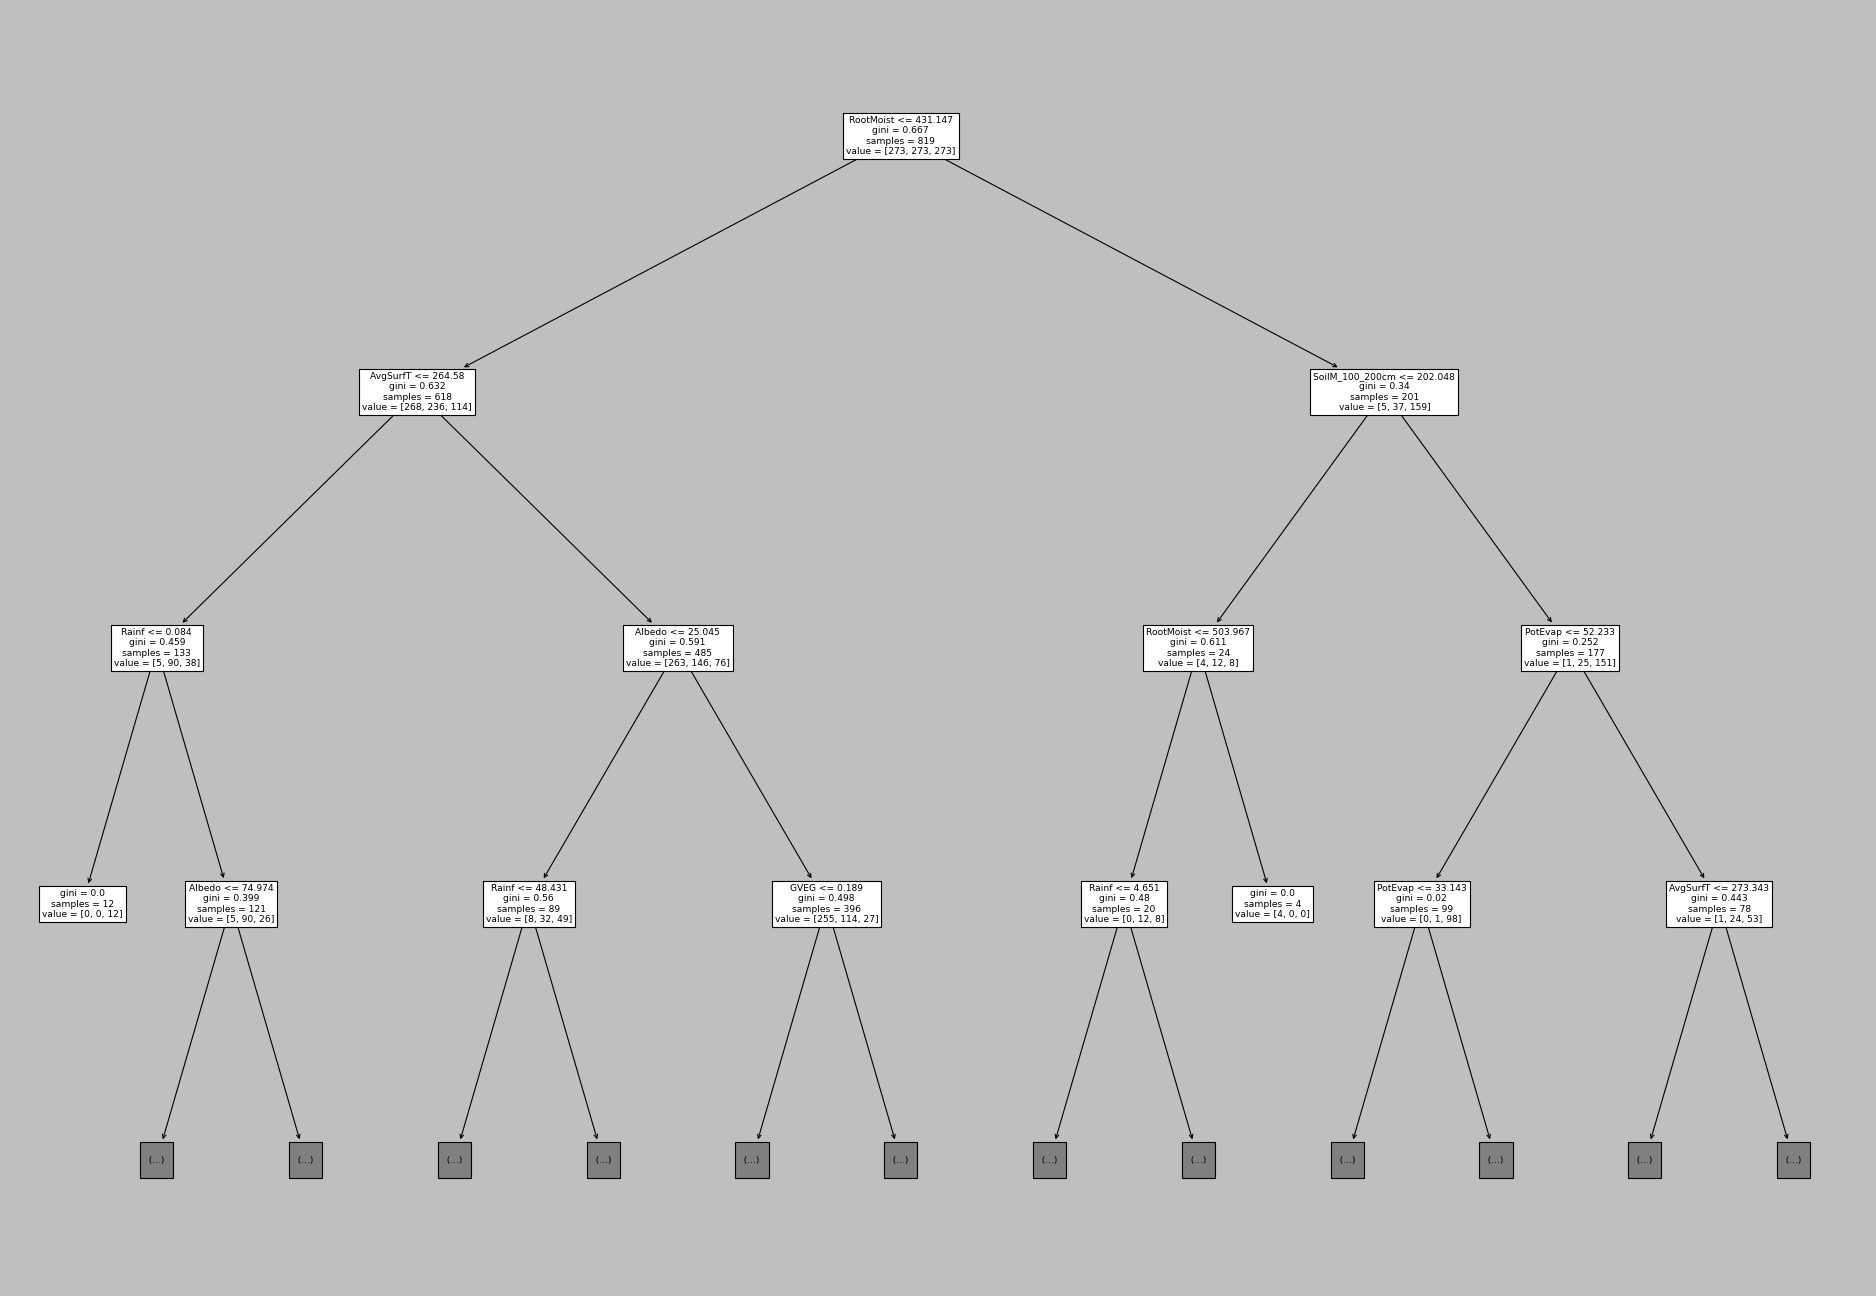

In [ ]:
%matplotlib inline
plt.style.use("classic")
plt.figure(figsize=(30,20))
tree.plot_tree(tree_classifier_m1, max_depth=3, feature_names=X_m1_train.columns);

#### Ocena modelu

Na zbalansowanych danych treningowych.

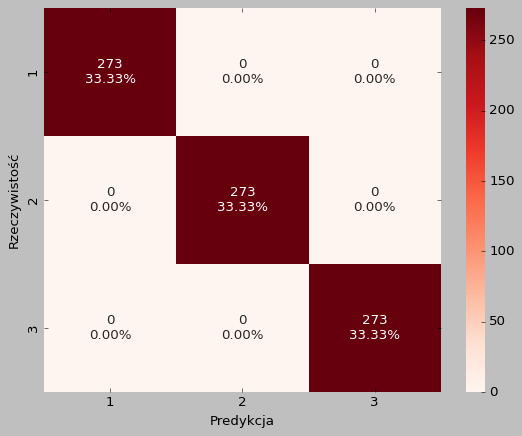

In [ ]:
summary_model(tree_classifier_m1, X_m1_train_bal, y_m1_train_bal, ['1','2','3'])

In [ ]:
print_classification_report(tree_classifier_m1, X_m1_train_bal, y_m1_train_bal)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       273
           2       1.00      1.00      1.00       273
           3       1.00      1.00      1.00       273

    accuracy                           1.00       819
   macro avg       1.00      1.00      1.00       819
weighted avg       1.00      1.00      1.00       819



Na danych testowych.

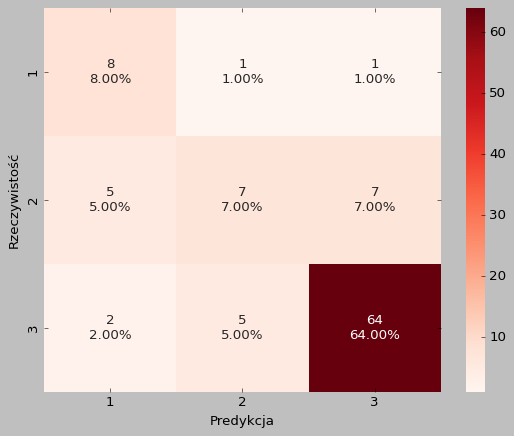

In [ ]:
summary_model(tree_classifier_m1, X_m1_test, y_m1_test, ['1','2','3'])

In [ ]:
print_classification_report(tree_classifier_m1, X_m1_test, y_m1_test)

              precision    recall  f1-score   support

           1       0.53      0.80      0.64        10
           2       0.54      0.37      0.44        19
           3       0.89      0.90      0.90        71

    accuracy                           0.79       100
   macro avg       0.65      0.69      0.66       100
weighted avg       0.79      0.79      0.78       100



#### Zapisanie modelu

In [ ]:
model_m1_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m1'

In [ ]:
#with open(model_m1_path, 'wb') as files:
#    pickle.dump(tree_classifier_m1, files)

### Model 2 - detekcja pustynia - niepustynia

#### Podzial na zbior treningowy i testowy

In [ ]:
X_m2_train, X_m2_test, y_m2_train, y_m2_test = train_test_split(X, y_m2, test_size=0.2, random_state=2023)

#### Analiza jednoczynnikowa

Obliczmy zysk informacji.

In [ ]:
information_gain(X_m2_train, y_m2_train)

Albedo             0.117184
RootMoist          0.083890
GVEG               0.048974
AvgSurfT           0.041764
SoilM_100_200cm    0.040617
PotEvap            0.035544
Rainf              0.013904
Evap               0.013900
SoilT_10_40cm      0.004758
dtype: float64


#### Analiza wieloczynnikowa

Obliczmy korelacje zmiennych.

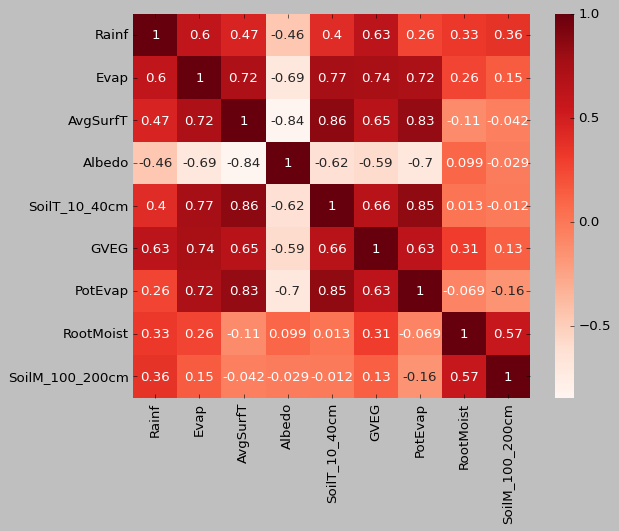

In [ ]:
correlations(X_m2_train)

Usuniecie zmiennej *SoilT_10_40cm*. Cechuja sie ona mała wartoscia zysku informacji. (Accurancy z tymi zmiennymi 85% dla zbioru testowego.)

In [ ]:
X_m2_train = X_m2_train.drop('SoilT_10_40cm',axis=1)
X_m2_test = X_m2_test.drop('SoilT_10_40cm',axis=1)

#### Zbalansowanie datasetu

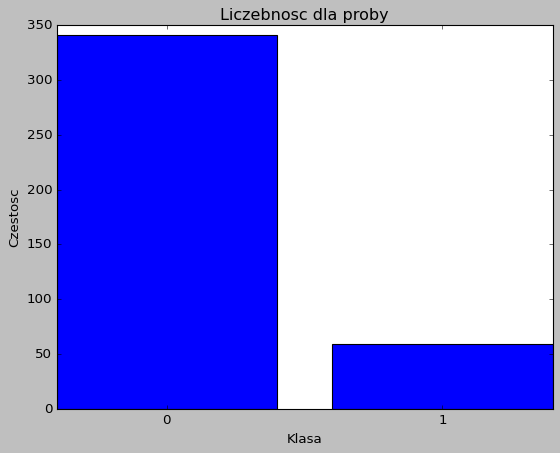

In [ ]:
plot_data_dist(y_m2_train)

In [ ]:
X_m2_train_bal, y_m2_train_bal = BalanceDataSet(X_m2_train, y_m2_train).useSMOTE()

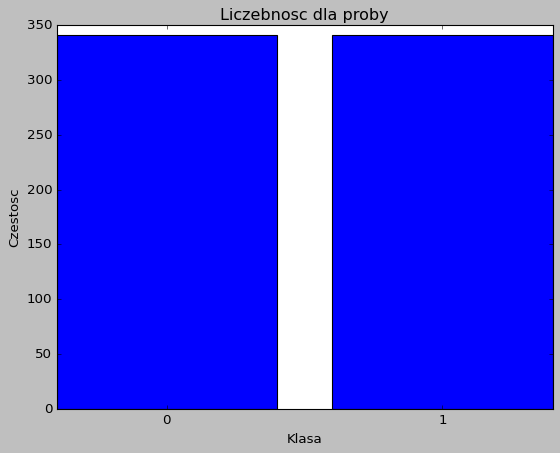

In [ ]:
plot_data_dist(y_m2_train_bal)

#### Drzewa decyzyjne

In [ ]:
tree_classifier_m2 = tree.DecisionTreeClassifier(random_state = 2023)

In [ ]:
tree_classifier_m2.fit(X_m2_train_bal, y_m2_train_bal)

DecisionTreeClassifier(random_state=2023)

In [ ]:
print("classifier accuracy {:.2f}%".format(tree_classifier_m2.score(X_m2_test,  y_m2_test) * 100))

classifier accuracy 88.00%


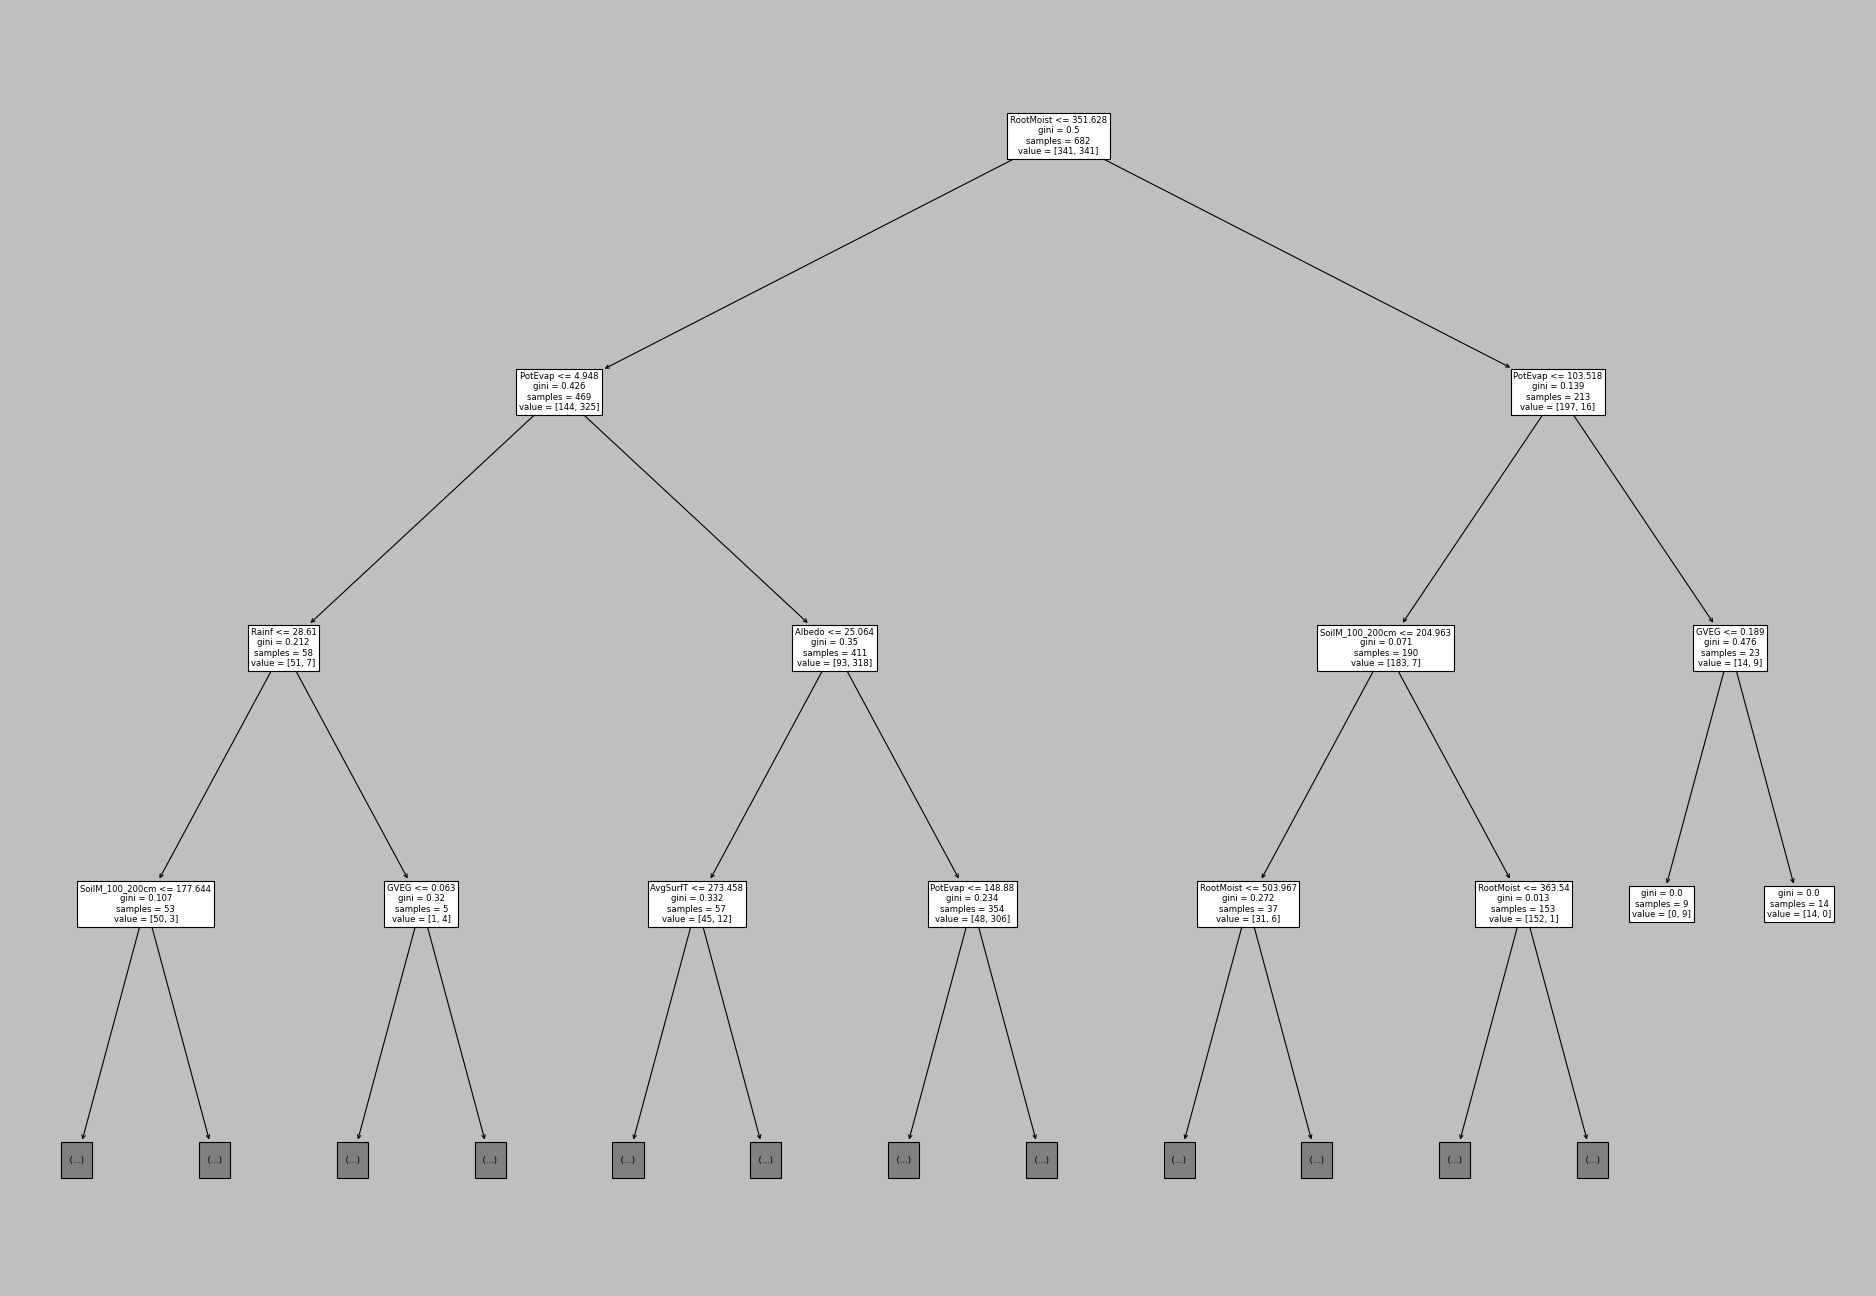

In [ ]:
%matplotlib inline
plt.style.use("classic")
plt.figure(figsize=(30,20))
tree.plot_tree(tree_classifier_m2, max_depth=3, feature_names=X_m2_train.columns);

#### Ocena modelu

Na zbalansowanych danych treningowych.

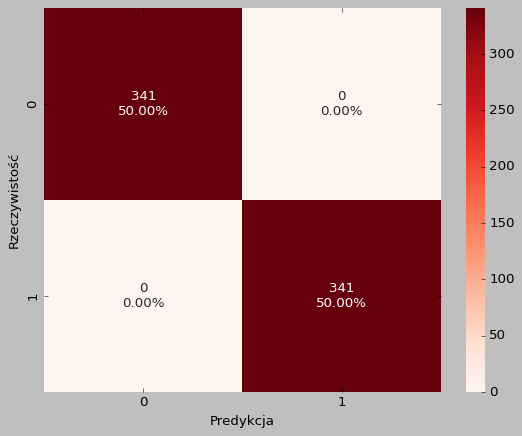

In [ ]:
summary_model(tree_classifier_m2, X_m2_train_bal, y_m2_train_bal, ['0', '1'])

In [ ]:
print_classification_report(tree_classifier_m2, X_m2_train_bal, y_m2_train_bal)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       341
           1       1.00      1.00      1.00       341

    accuracy                           1.00       682
   macro avg       1.00      1.00      1.00       682
weighted avg       1.00      1.00      1.00       682



Na danych testowych.

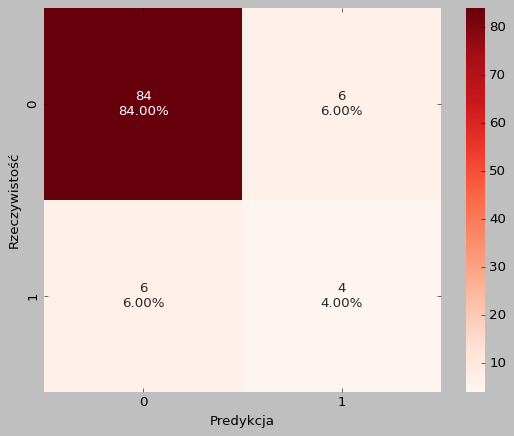

In [ ]:
summary_model(tree_classifier_m2, X_m2_test, y_m2_test, ['0', '1'])

In [ ]:
print_classification_report(tree_classifier_m2, X_m2_test, y_m2_test)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        90
           1       0.40      0.40      0.40        10

    accuracy                           0.88       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.88      0.88      0.88       100



#### Zapisanie modelu

In [ ]:
model_m2_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m2'

In [ ]:
#with open(model_m2_path, 'wb') as files:
#    pickle.dump(tree_classifier_m2, files)

### Model 3 - detekcja step - niestep

#### Podzial na zbior treningowy i testowy

In [ ]:
X_m3_train, X_m3_test, y_m3_train, y_m3_test = train_test_split(X, y_m3, test_size=0.2, random_state=2023)

#### Analiza jednoczynnikowa

Obliczmy zysk informacji.

In [ ]:
information_gain(X_m3_train, y_m3_train)

RootMoist          0.056707
Rainf              0.054649
SoilT_10_40cm      0.038391
Albedo             0.027094
SoilM_100_200cm    0.021524
GVEG               0.014149
PotEvap            0.003627
Evap               0.000000
AvgSurfT           0.000000
dtype: float64


#### Analiza wieloczynnikowa

Obliczmy korelacje zmiennych.

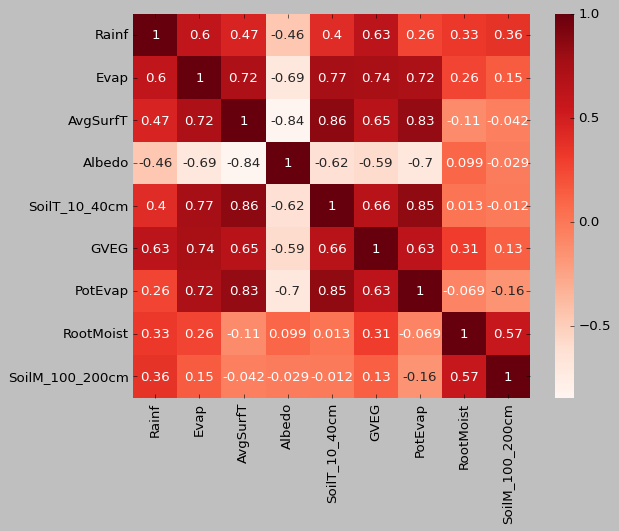

In [ ]:
correlations(X_m3_train)

Usuniecie zmiennych *AvgSurfT*, *Evap* i *PotEvap*. Cechuja sie one mała wartoscia zysku informacji. (Accurancy z tymi zmiennymi 78% dla zbioru testowego.)

In [ ]:
X_m3_train = X_m3_train.drop('AvgSurfT',axis=1)
X_m3_test = X_m3_test.drop('AvgSurfT',axis=1)
X_m3_train = X_m3_train.drop('Evap',axis=1)
X_m3_test = X_m3_test.drop('Evap',axis=1)
X_m3_train = X_m3_train.drop('PotEvap',axis=1)
X_m3_test = X_m3_test.drop('PotEvap',axis=1)

#### Zbalansowanie datasetu

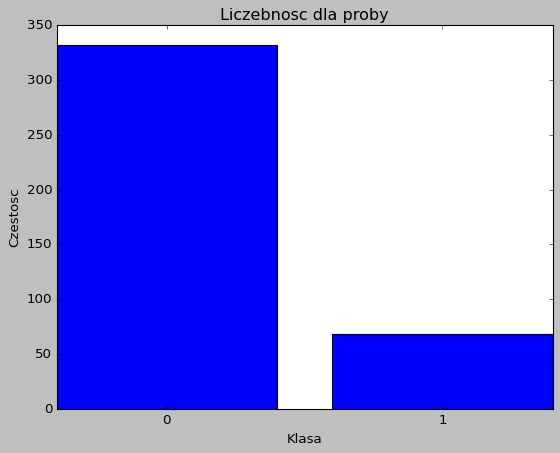

In [ ]:
plot_data_dist(y_m3_train)

In [ ]:
X_m3_train_bal, y_m3_train_bal = BalanceDataSet(X_m3_train, y_m3_train).useSMOTE()

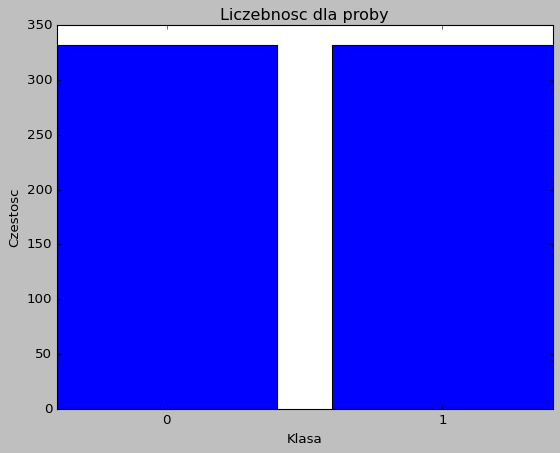

In [ ]:
plot_data_dist(y_m3_train_bal)

#### Drzewa decyzyjne

In [ ]:
tree_classifier_m3 = tree.DecisionTreeClassifier(random_state = 2023)

In [ ]:
tree_classifier_m3.fit(X_m3_train_bal, y_m3_train_bal)

DecisionTreeClassifier(random_state=2023)

In [ ]:
print("classifier accuracy {:.2f}%".format(tree_classifier_m3.score(X_m3_test,  y_m3_test) * 100))

classifier accuracy 83.00%


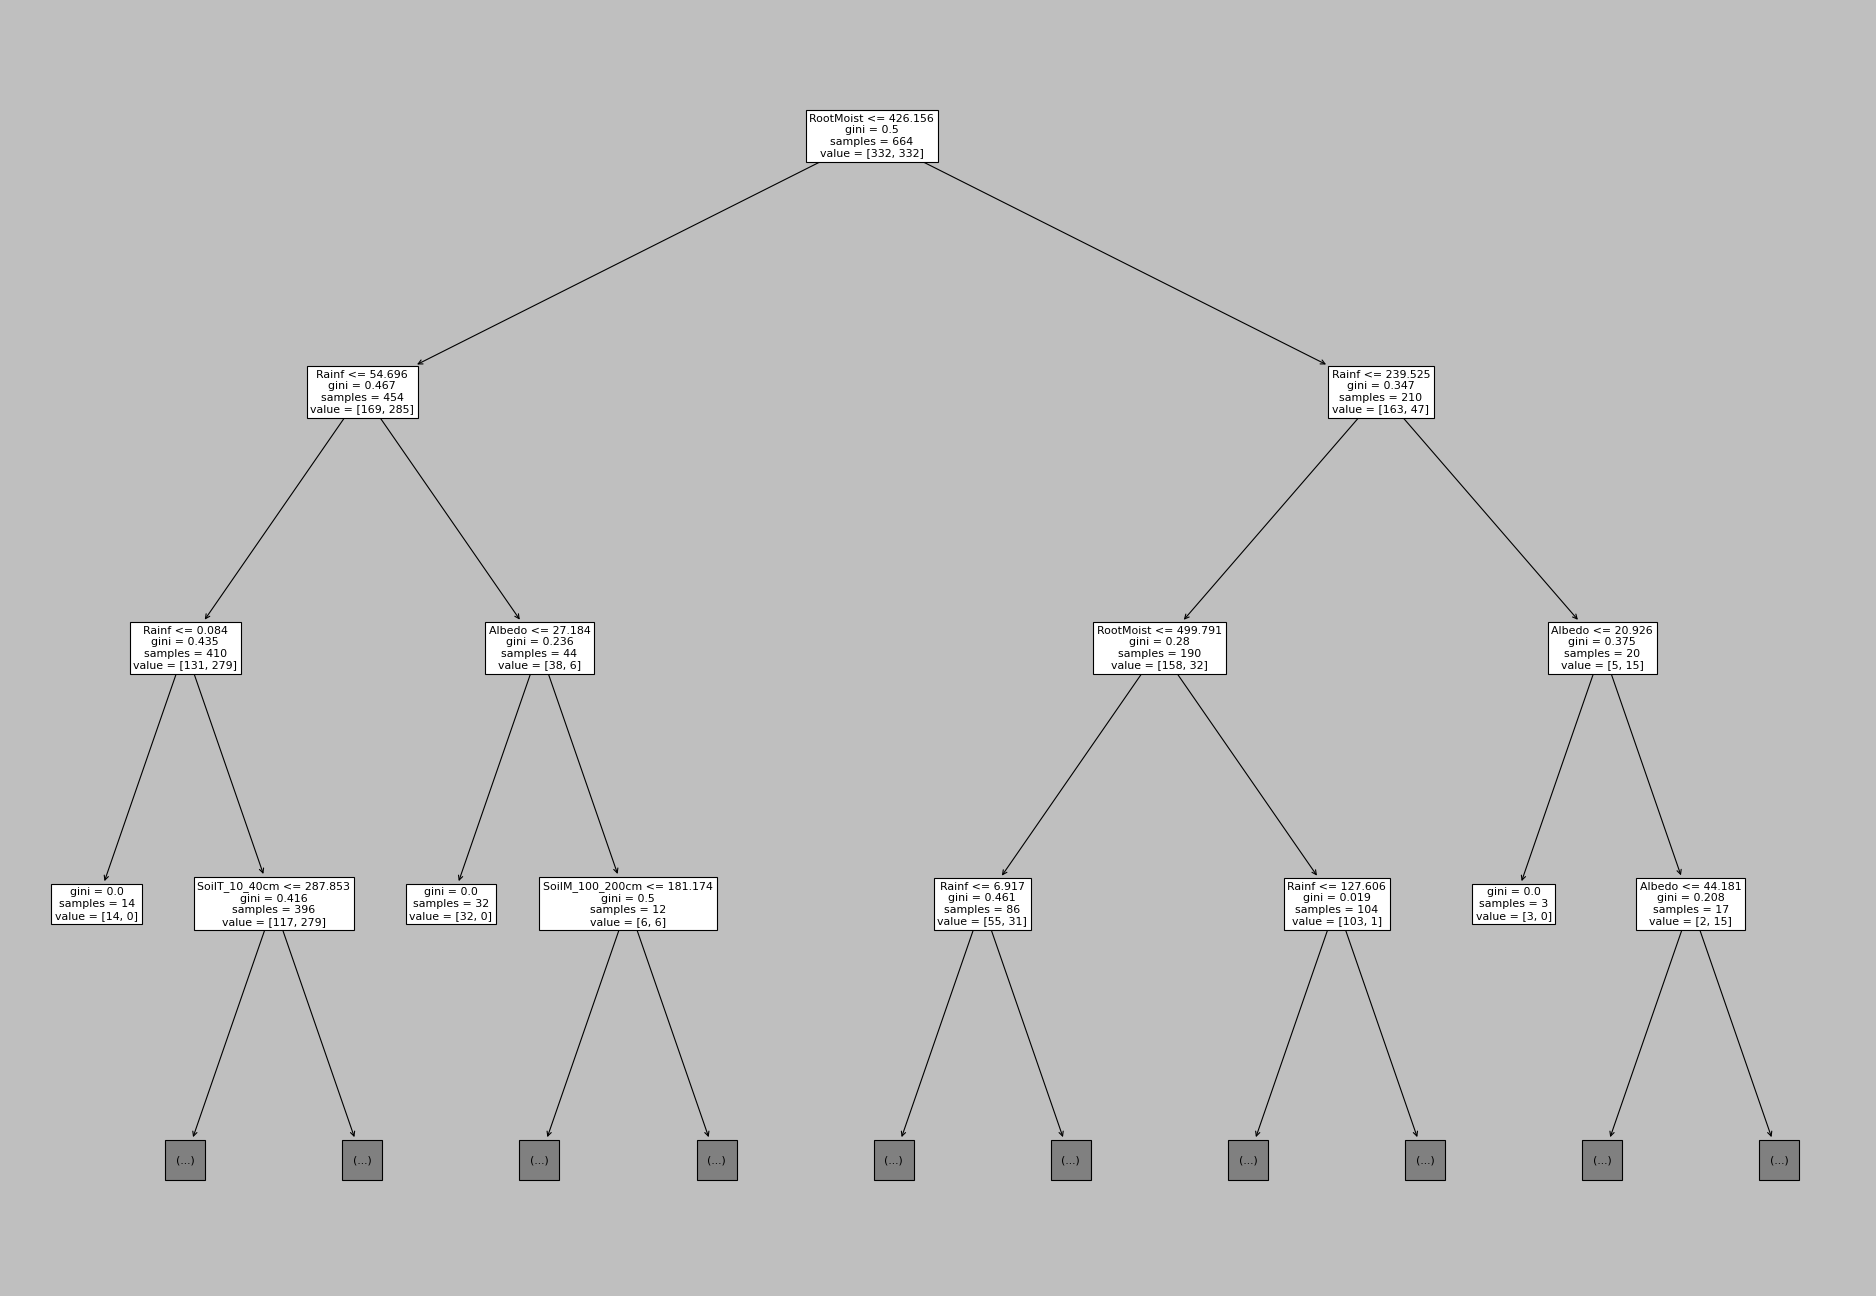

In [ ]:
%matplotlib inline
plt.style.use("classic")
plt.figure(figsize=(30,20))
tree.plot_tree(tree_classifier_m3, max_depth=3, feature_names=X_m3_train.columns);

#### Ocena modelu

Na zbalansowanych danych treningowych.

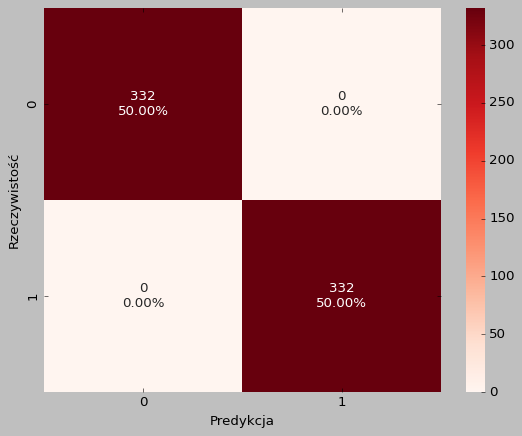

In [ ]:
summary_model(tree_classifier_m3, X_m3_train_bal, y_m3_train_bal, ['0', '1'])

In [ ]:
print_classification_report(tree_classifier_m3, X_m3_train_bal, y_m3_train_bal)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       332
           1       1.00      1.00      1.00       332

    accuracy                           1.00       664
   macro avg       1.00      1.00      1.00       664
weighted avg       1.00      1.00      1.00       664



Na danych testowych.

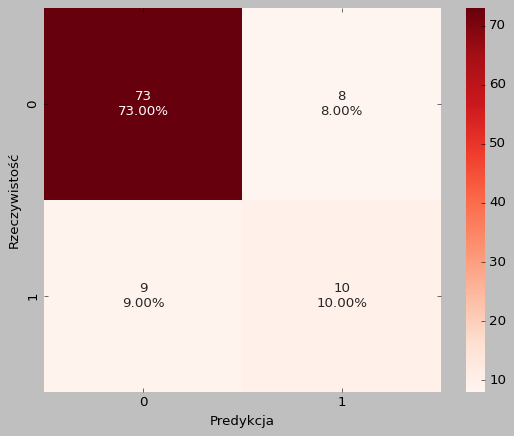

In [ ]:
summary_model(tree_classifier_m3, X_m3_test, y_m3_test, ['0', '1'])

In [ ]:
print_classification_report(tree_classifier_m3, X_m3_test, y_m3_test)

              precision    recall  f1-score   support

           0       0.89      0.90      0.90        81
           1       0.56      0.53      0.54        19

    accuracy                           0.83       100
   macro avg       0.72      0.71      0.72       100
weighted avg       0.83      0.83      0.83       100



#### Zapisanie modelu

In [ ]:
model_m3_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m3'

In [ ]:
#with open(model_m3_path, 'wb') as files:
#    pickle.dump(tree_classifier_m3, files)

### Podsumowanie

**Model 1 - detekcja pustynia - step - inne** \
Zmienne:

*	Rainf              
*	Evap
* PotEvap                
*	AvgSurfT           
*	Albedo             
*	SoilM_100_200cm
*	GVEG                           
*	RootMoist          


Zwraca *1*, *2* lub *3* gdzie:
* 1 - pustynia
* 2 - step
* 3 - inne


**Model 2 - detekcja pustynia - niepustynia** \
Zmienne:

*	Rainf              
*	Evap
* PotEvap                
*	AvgSurfT           
*	Albedo             
*	SoilM_100_200cm
*	GVEG                           
*	RootMoist        


Zwraca *0* lub *1* gdzie:
* 0 - niepustynia
* 1 - pustynia



**Model 3 - detekcja step - niestep** \
Zmienne:

*	Rainf              
*	SoilT_10_40cm                           
*	Albedo             
*	SoilM_100_200cm
*	GVEG                           
*	RootMoist       


Zwraca *0* lub *1* gdzie:
* 0 - niestep
* 1 - step


Sciezki do modeli:

In [ ]:
model_m1_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m1'
model_m2_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m2'
model_m3_path='/content/drive/MyDrive/BigMess/NASA/Modele/Klasyfikacja/tree_classifier_m3'

Przykladowy odczyt modelu.

In [ ]:
with open(model_m1_path , 'rb') as f:
    model = pickle.load(f)